## The Imports

In [1]:
import geopandas as gpd
import geoplot as gplt
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.legend import Legend
import matplotlib.patches as mpatches
from handlers.TextLegendHandler import TextHandler

# set up a handler for text legends
Legend.update_default_handler_map({str : TextHandler()})

# update default font
plt.rcParams['font.family'] = 'Frutiger Light Condensed'

### Import the geographical and the election result data 
##### The topojson contains data for the whole of nepal, select only the Kathmandu Palika geo data
##### Merge the election data and the geographic data based on the ward

In [3]:
elec_data = pd.read_csv('../../data/election_data/ward votes sample.csv')
map_data = gpd.read_file('../../data/nepal_map_data/nepal-wards.topojson')

wards_data_ktm = map_data.query('PALIKA.str.contains("Kathmandu")', engine='python')
wards_data_ktm = wards_data_ktm.merge(elec_data, how='inner', left_on=["WARD"], right_on=["Ward"]).iloc[:,1:]

# dissolved data for the entire mulicipality
dissolved_data = wards_data_ktm.copy().dissolve(by='PALIKA')

### Global var definition for plot kwargs

In [4]:
# dict for the ward number -> name legend
ward_legend_dict = {}
for _, v in wards_data_ktm[['WARD', 'Area']].sort_values(by='WARD').iterrows():
    ward_legend_dict[str(v['WARD'])] = v['Area']
    
# properties for the ward label legend
ward_legend_kwargs = {
        "handles" : ward_legend_dict.keys(),
        "labels" : ward_legend_dict.values(),
        "fontsize" : 25,
        "fancybox" : True, 
        "frameon" : True,
        "framealpha" : 0.7,
        "loc" : 'center left',
        "borderpad" : 1,
    }
    
# candidates and their properties
candidate_dict = {
    'Balendra Shah' : 'Blues',
    'Keshav Sthapit' : 'Reds',
    'Shrijana Singh' : 'Greens',
    'Suman Sayami' : 'Purples'
    }

# finding the winner for each ward
wards_data_ktm['winner'] = wards_data_ktm[candidate_dict.keys()].idxmax(axis=1)


# properties for the choropleth map
map_kwargs = {
    "alpha" : 0.9, 
    "edgecolor" : '#dae8f5', 
    "figsize" : (32,28),   
}

ANNOTATION_KWARGS ={
    "fontstretch" : 'ultra-expanded',  
    "ha" : 'left',
    "bbox" : {
        'facecolor' : 'white', 
        'alpha' : 0.3, 
        'pad' : 2, 
        'edgecolor' : 'none'
        }
}


### Utility functions

In [5]:
def annotate_wards(axis, wards_data_ktm, annotation_kwargs=ANNOTATION_KWARGS):
    """
    Args:
        axis (matplotlib.axes): the figure axis
        wards_data_ktm (geopandas dataframe object): ktm ward geodataframe
        annotation_kwargs (dict, optional): kwargs for axis.annotate(). Defaults to ANNOTATION_KWARGS.
    """
    min_area_ward = wards_data_ktm.geometry.area.min()
    for geometry, label, name in zip(wards_data_ktm.geometry, wards_data_ktm.WARD, wards_data_ktm.Area):
        xycoords = (geometry.centroid.coords[0][0]-0.0006,geometry.centroid.coords[0][1]) if label != 32 else (geometry.centroid.coords[0][0]-0.0084,geometry.centroid.coords[0][1]-0.005)
        axis.annotate(
            text=label, 
            xy=xycoords, 
            label=name,
            fontsize = 15+ 0.7*(geometry.area / min_area_ward),
            **annotation_kwargs
            )

### Vote percentage by ward

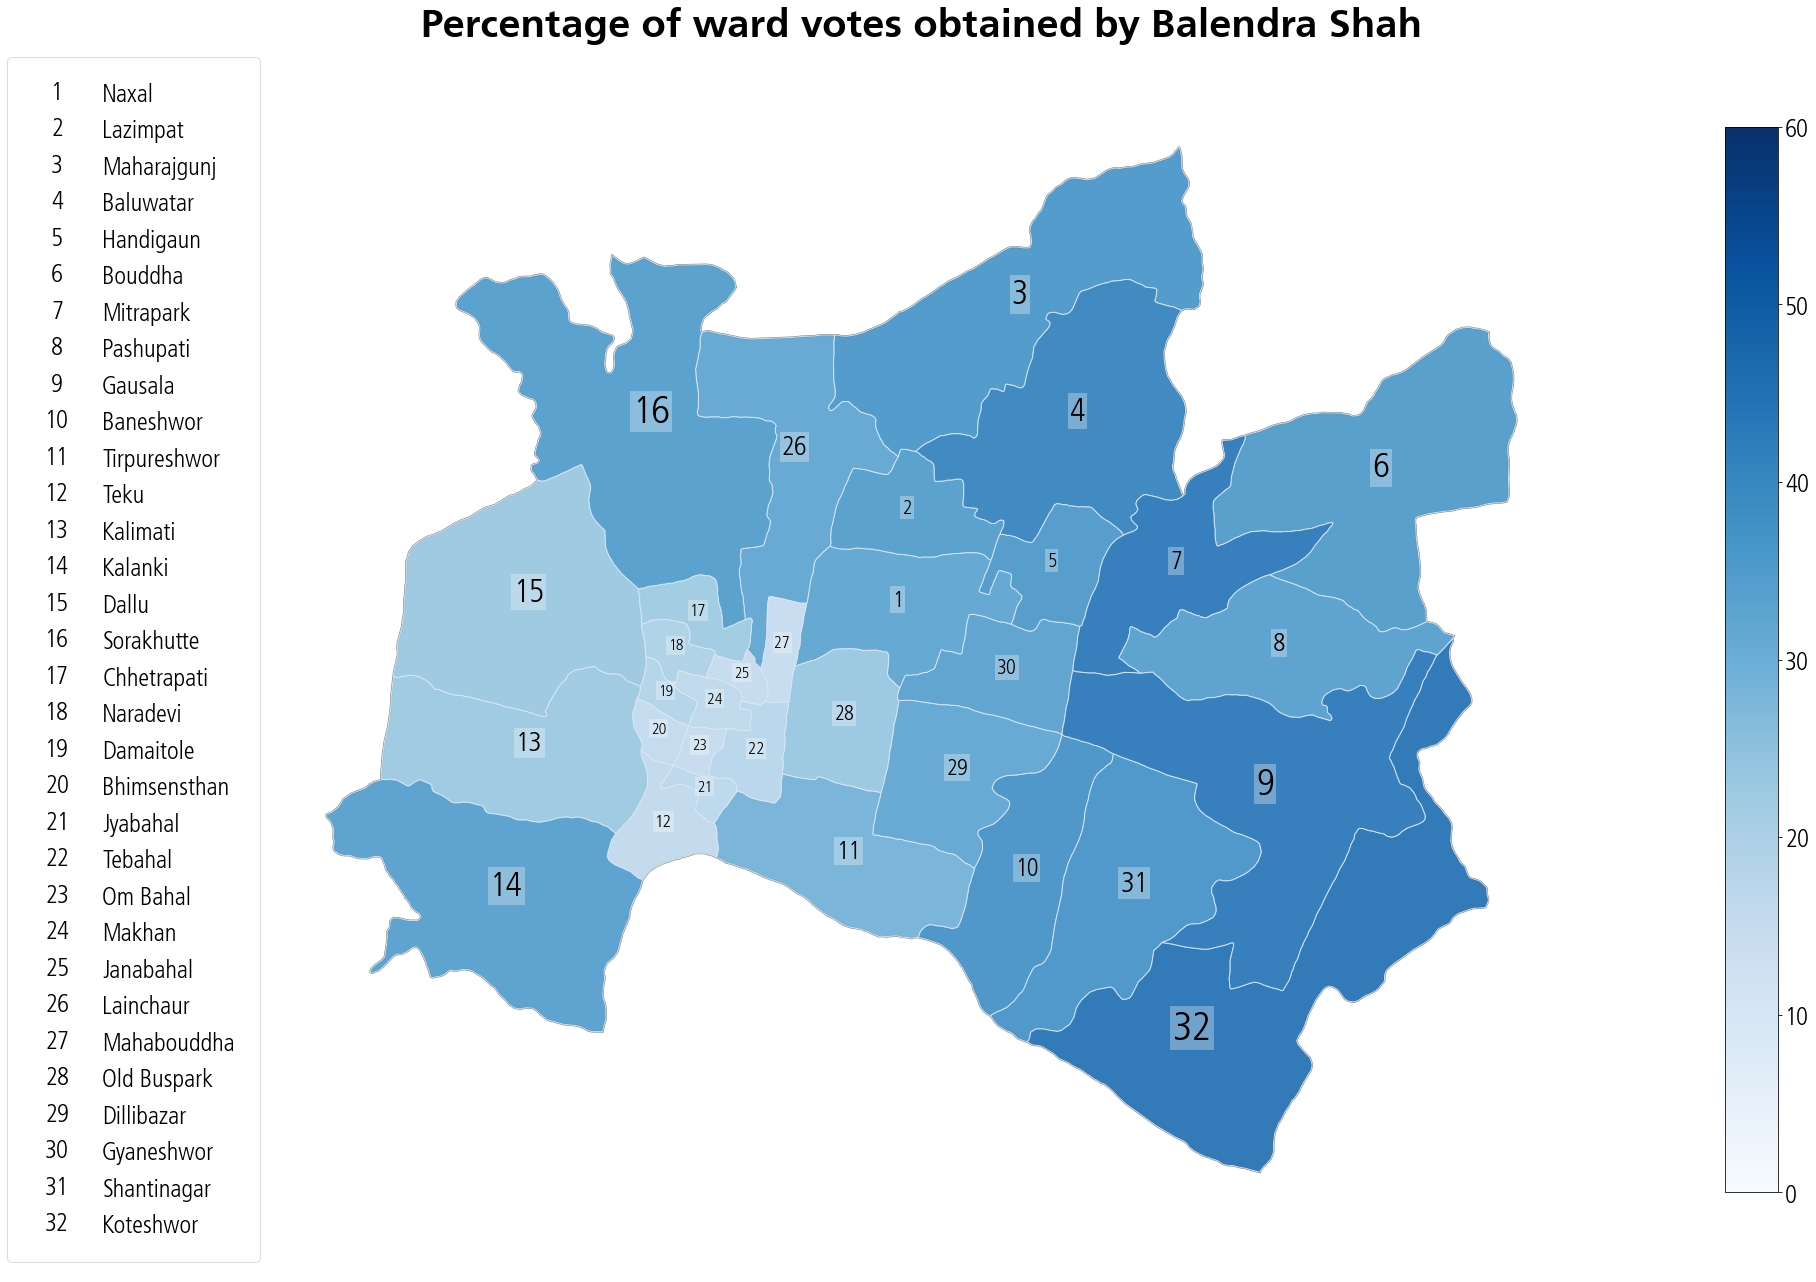

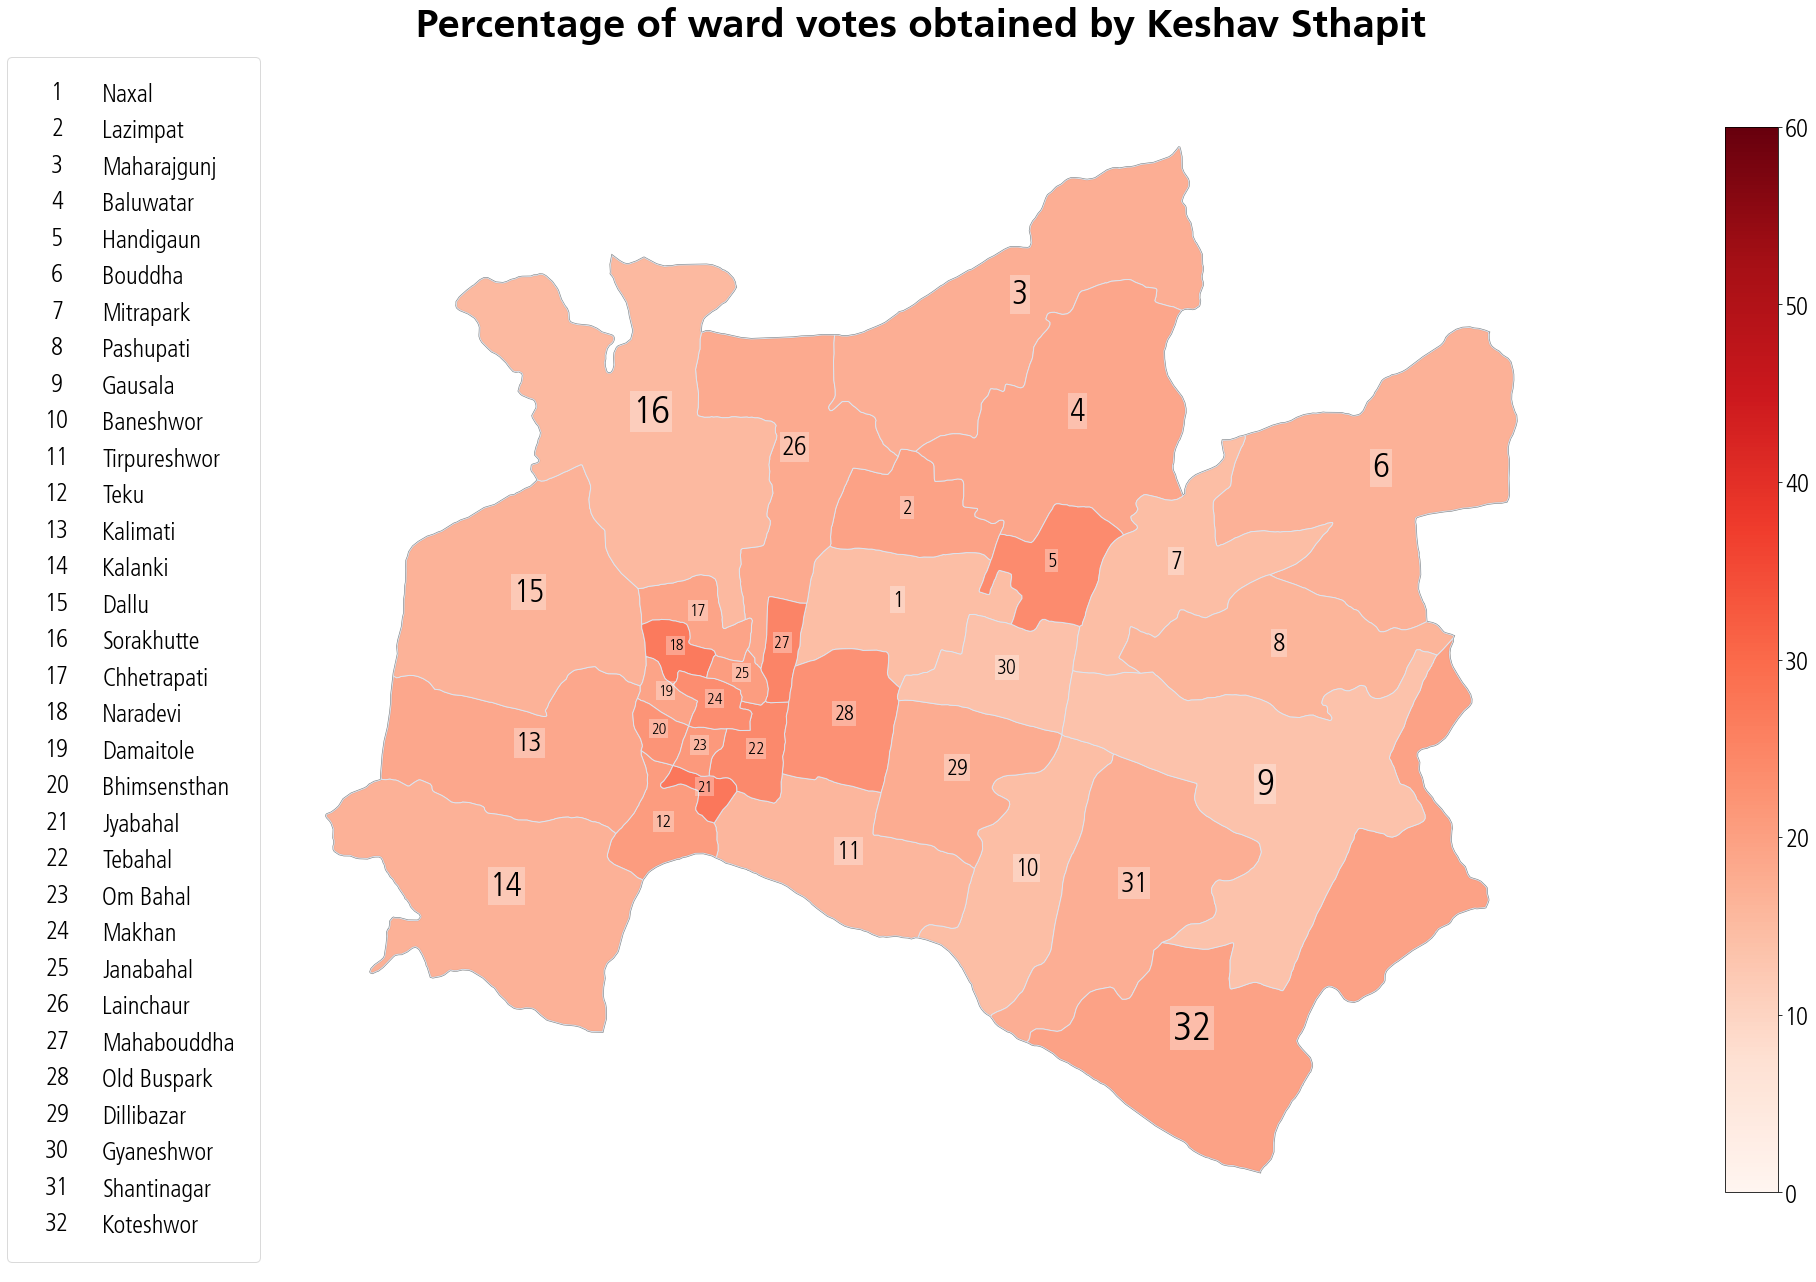

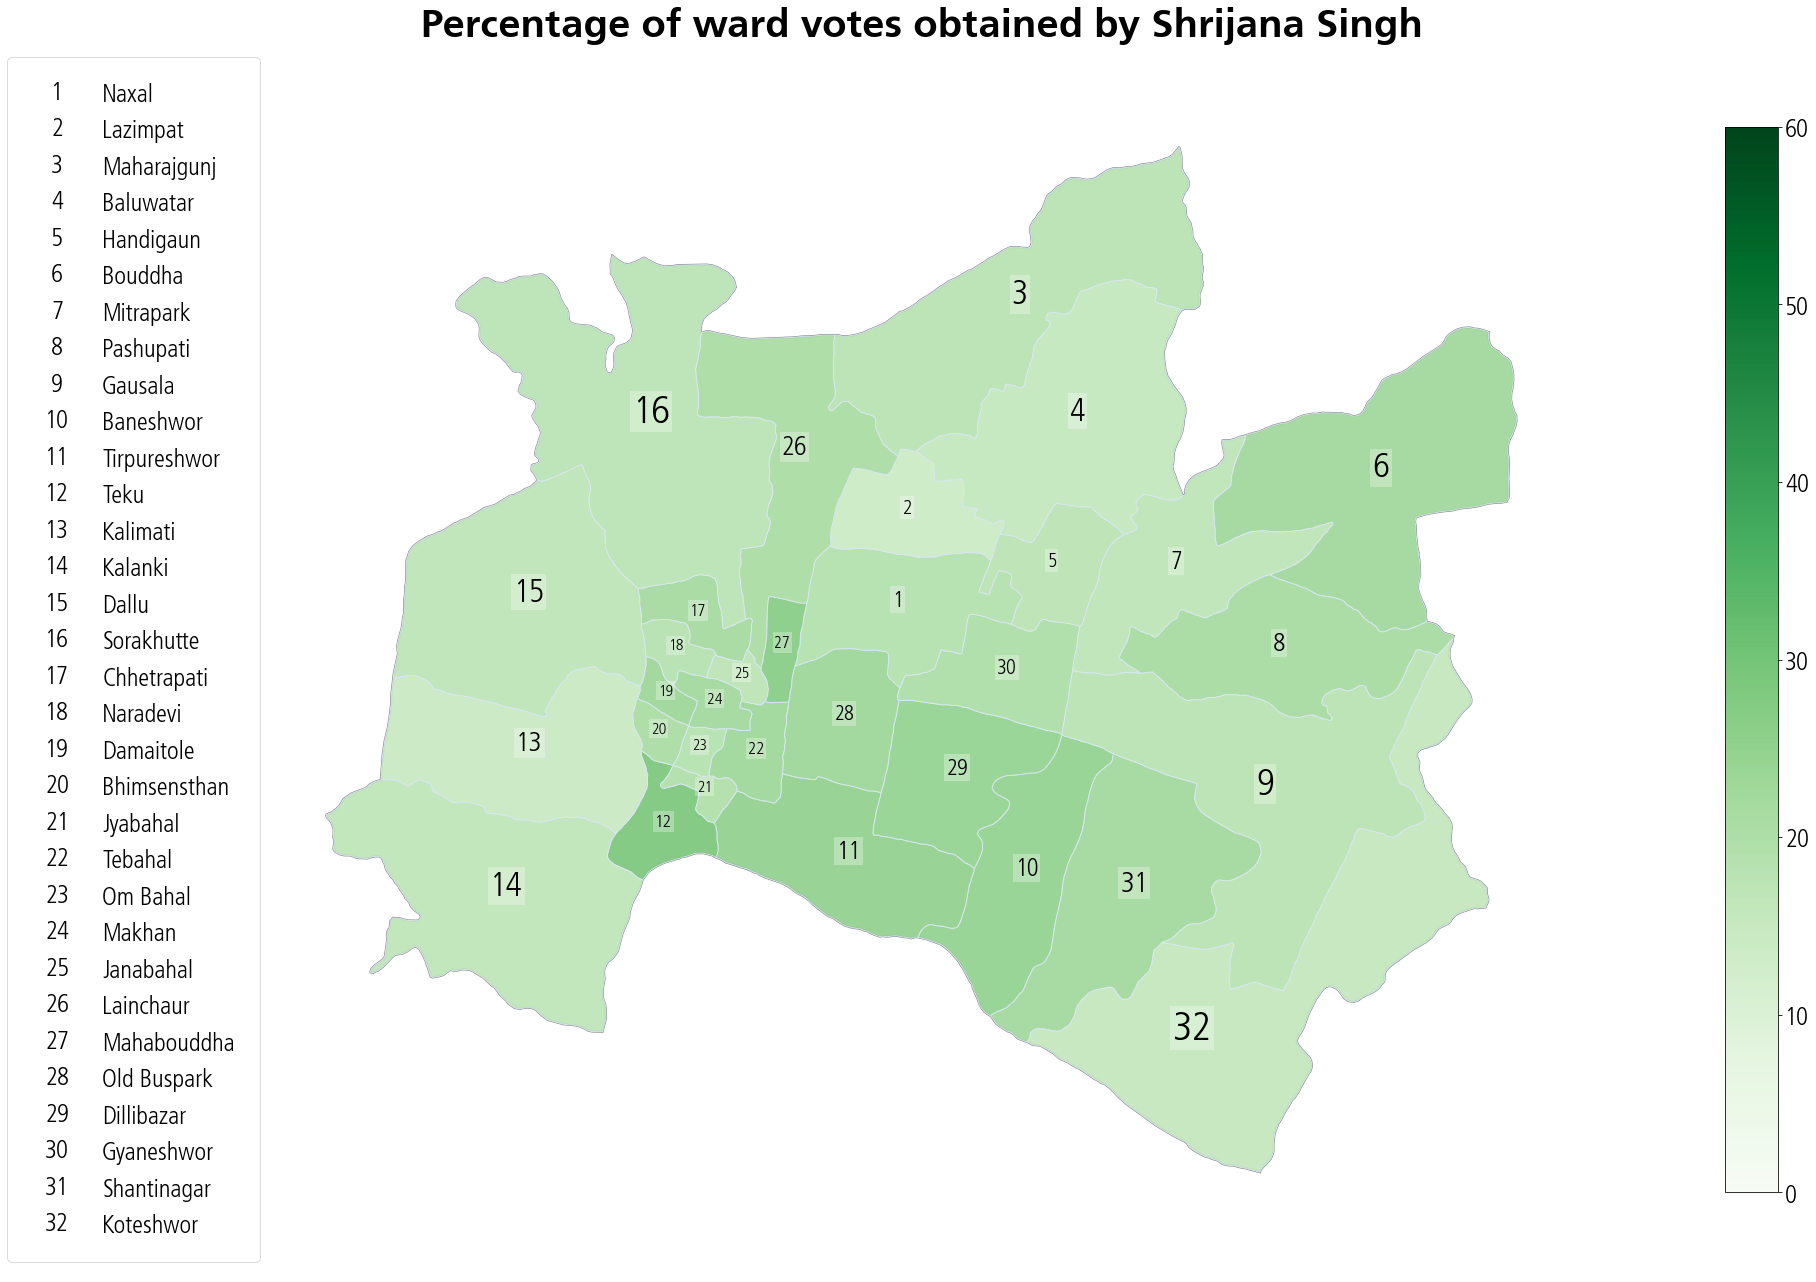

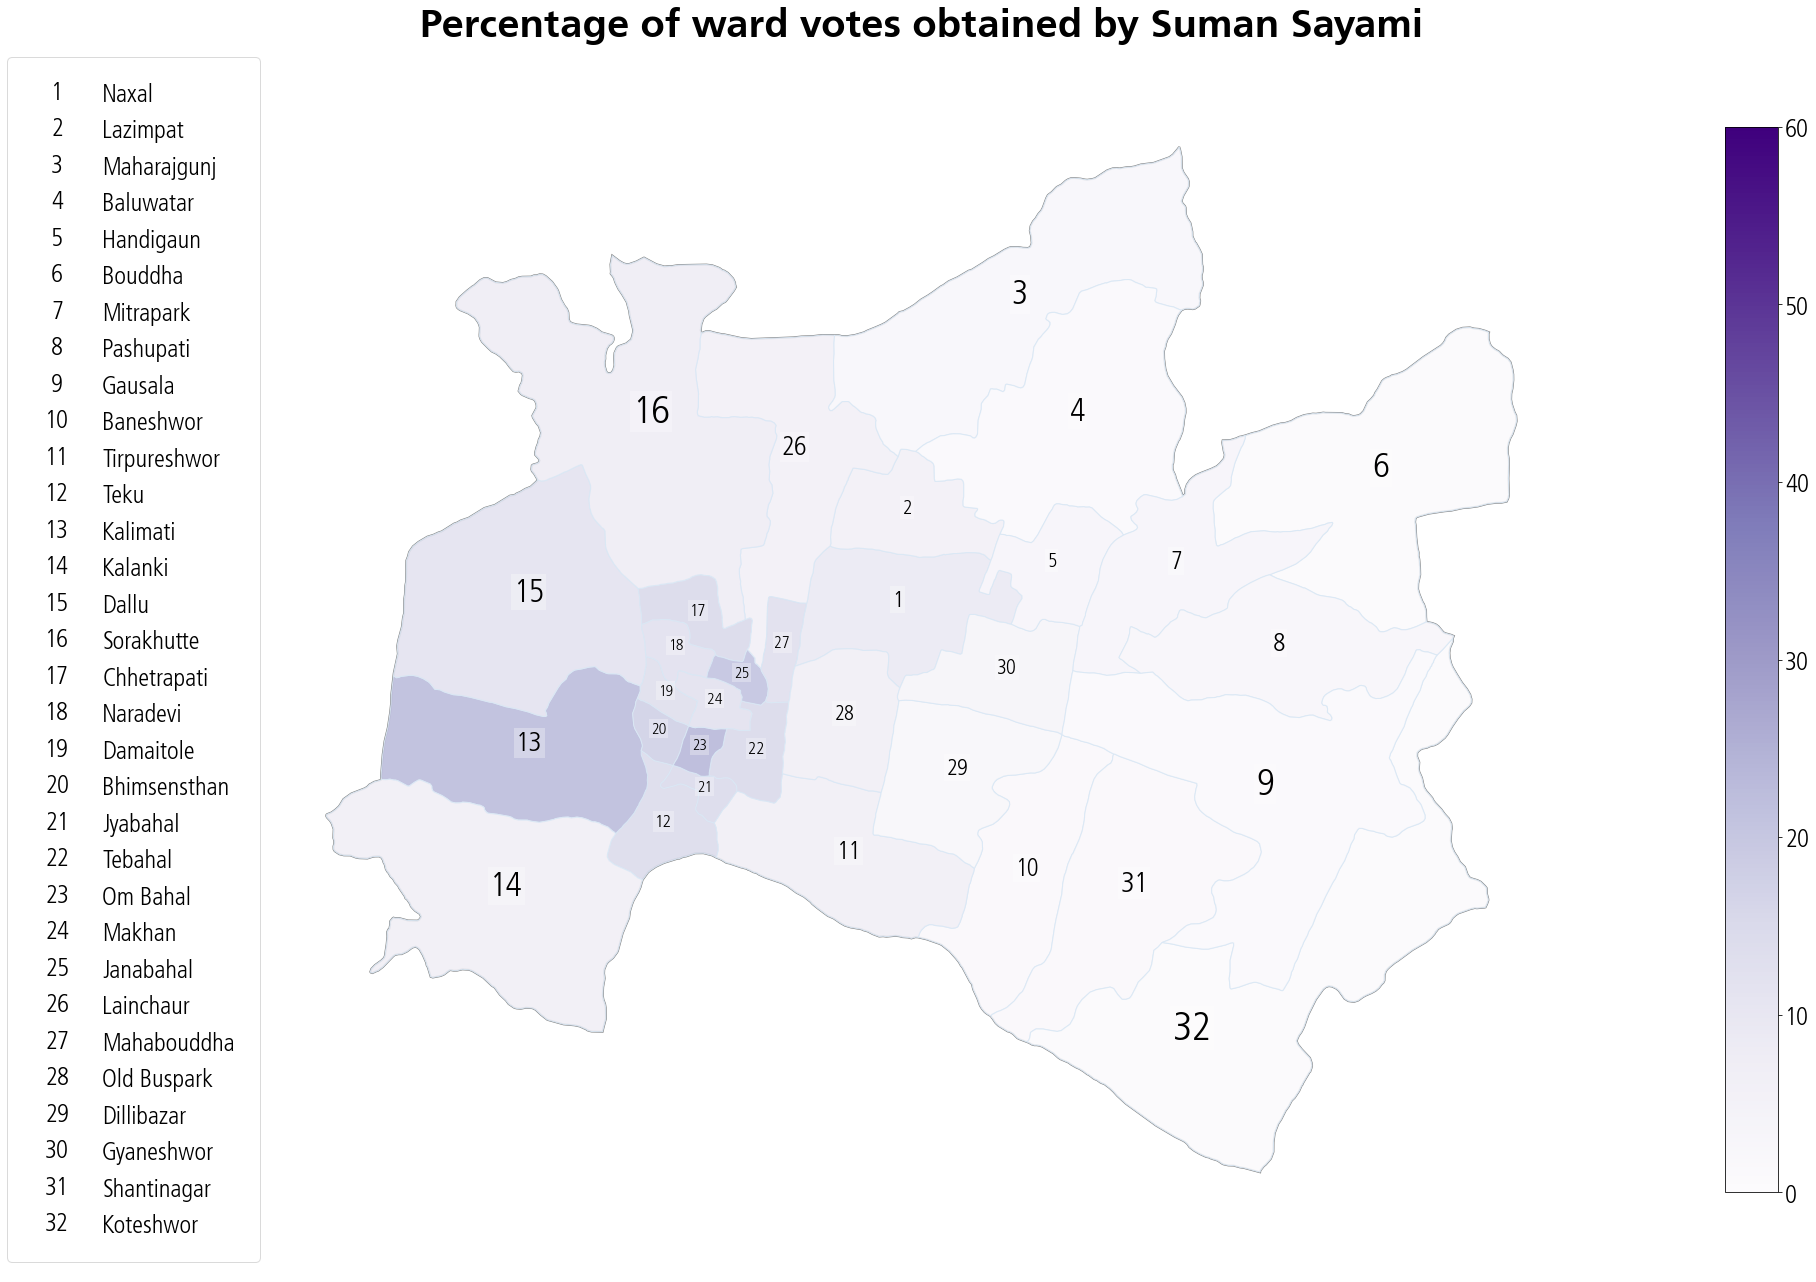

In [5]:
for (candidate, pallete) in candidate_dict.items():
    field = candidate.split()[1] + " %"
    
    #defining a custom color map to plot everyone's color intensity proportionate to the votes from 0-60%
    norm = matplotlib.colors.Normalize(vmin=0, vmax=60)
    cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=pallete).cmap
    
    axis = gplt.choropleth(
        wards_data_ktm, 
        hue=field,
        cmap=cmap,
        norm=norm,
        legend = True,
        legend_kwargs={
            'orientation' : 'vertical',
            'shrink' : 0.7
        },
        **map_kwargs
        )
    # the outline of the metro
    gplt.polyplot(
        dissolved_data,
        linewidth=2,
        edgecolor='gray',
        linestyle='-',
        ax=axis
    )
    
    # matplotlib has no easy way to change fonts for colormaps
    axis.get_figure().get_axes()[1].tick_params(labelsize=25)
    
    annotate_wards(axis, wards_data_ktm)

    # add a legend for ward number -> war name annotation
    plt.legend(borderaxespad = -8, **ward_legend_kwargs)
    
    plt.title(f"Percentage of ward votes obtained by {candidate}",fontname='Frutiger Bold', fontsize=40)
    plt.savefig(f"../visualizations/election/{candidate} Proportion of votes in Kathmandu.jpg", bbox_inches='tight', pad_inches=1, dpi=200)

### Plotting the winners by ward

#### Data prep

In [6]:
cmap = 'tab20c'

# need to sort to get the right color combination, it seems choropleth's cmap and matplotlib's cmap have a different color order
winners = np.sort(wards_data_ktm['winner'].unique())
winner_color_dict = {winner:color for winner, color in zip(winners, cm.get_cmap(cmap)(np.linspace(0, 1, len(winners))))}

winner_color_kwargs = {
    "handles" : [mpatches.Patch(color=color, label=winner) for winner, color in winner_color_dict.items()], 
    "fontsize" : 30, 
    "fancybox" : True,
    "framealpha" : 0.7,
    "handlelength" : 3,
    "handleheight" : 1.5,
    "markerscale" : 3,
    "borderpad" : 1,
    "borderaxespad" : -4,
    "frameon" : True,
    "loc" : 'lower center',
    "ncol" : len(winners)
}

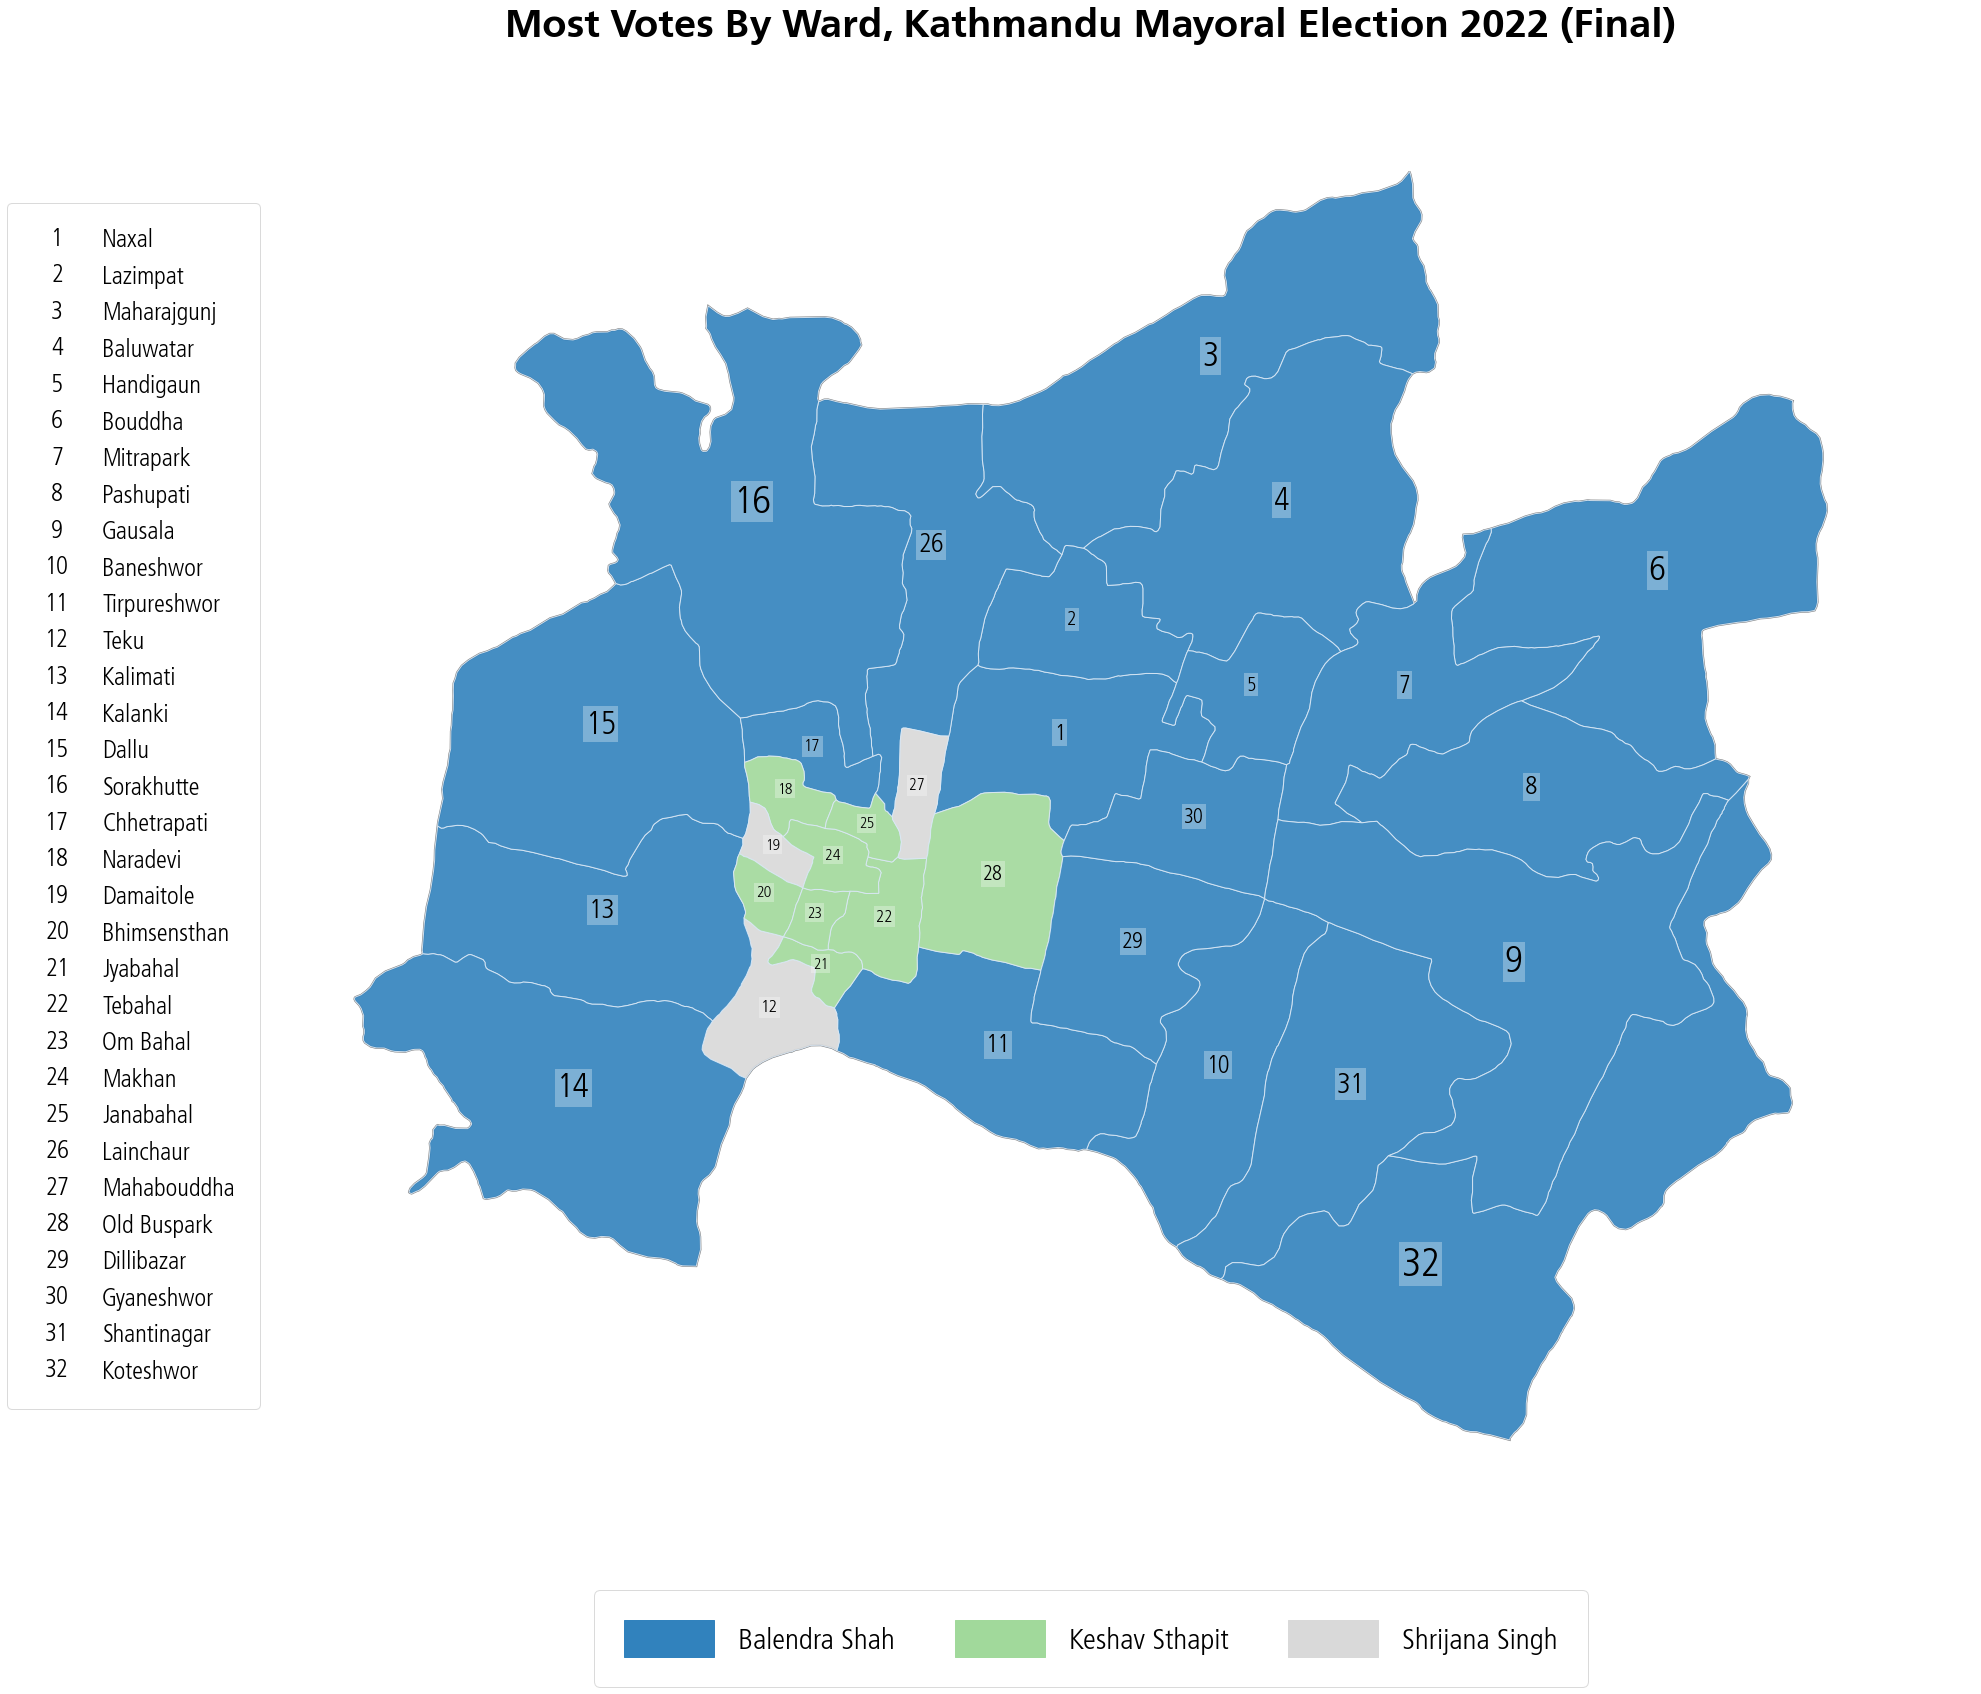

In [7]:
axis = gplt.choropleth(
    wards_data_ktm, 
    hue='winner',
    cmap=cmap,
    **map_kwargs,
    )
gplt.polyplot(
        dissolved_data,
        linewidth=2,
        edgecolor='gray',
        linestyle='-',
        ax=axis
    )

annotate_wards(axis, wards_data_ktm)
winner_color_legend = plt.legend(**winner_color_kwargs)
plt.legend(borderaxespad = -8, **ward_legend_kwargs)
plt.gca().add_artist(winner_color_legend)

plt.title("Most Votes By Ward, Kathmandu Mayoral Election 2022 (Final)", fontname='Frutiger Bold', fontsize=40)
plt.savefig('../visualizations/election/most votes Kathmandu.jpg', bbox_inches='tight', pad_inches=1)

### Winner vote difference mapping

In [8]:
# data prep
candidate_votes_df = wards_data_ktm[candidate_dict.keys()]
# find diff btwn largest and second largest votes in the ward
wards_data_ktm['win difference'] = candidate_votes_df.apply(lambda row: row.nlargest(1).values[-1],axis=1) - candidate_votes_df.apply(lambda row: row.nlargest(2).values[-1],axis=1)
winner_dfs = [(wards_data_ktm.loc[wards_data_ktm['winner']==winner], winner, cmap) for winner, cmap in candidate_dict.items()]

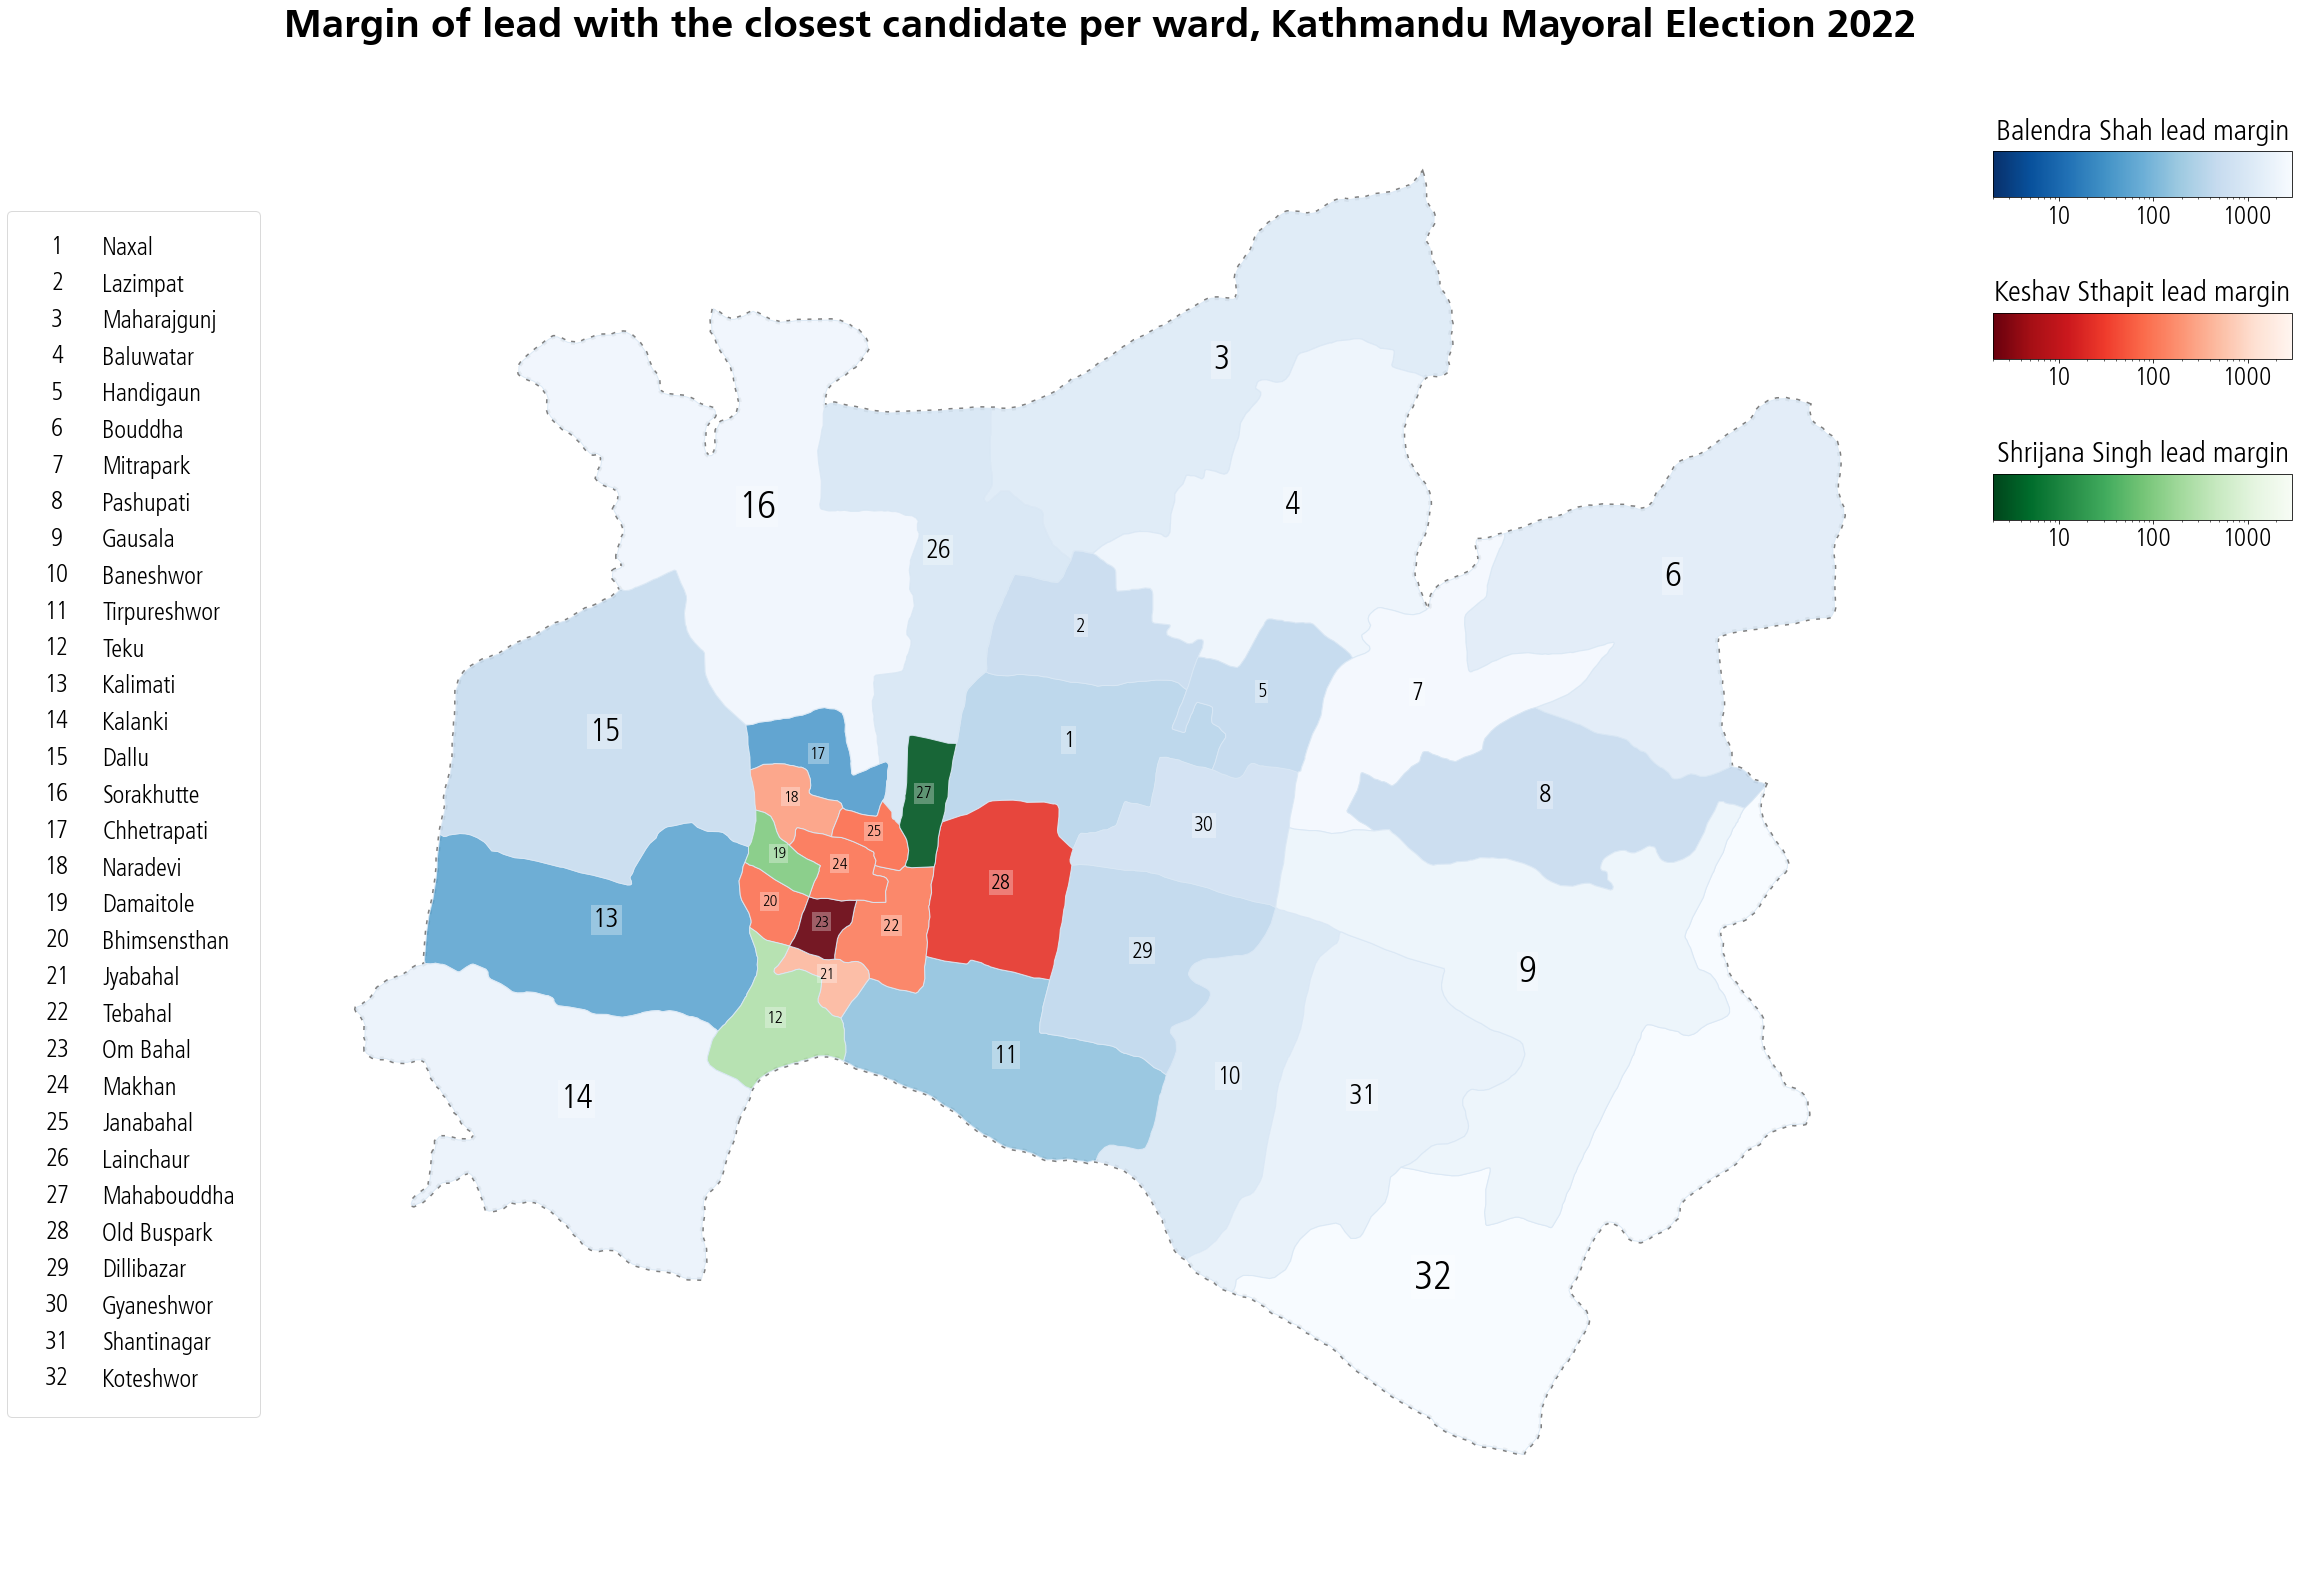

In [59]:
# the outline of the metro
axis = gplt.polyplot(
        dissolved_data,
        linewidth=4,
        edgecolor='gray',
        figsize=(32,32),
        linestyle=':'
    )
plt.title(f"Margin of lead with the closest candidate per ward, Kathmandu Mayoral Election 2022", fontname='Frutiger Bold', fontsize=40)
annotate_wards(axis, wards_data_ktm)
plt.legend(borderaxespad=-8, **ward_legend_kwargs)
for idx, (df, winner, cmap) in enumerate(winner_dfs):
    if len(df) != 0:
        figure = axis.get_figure()
        gplt.choropleth(
            df, 
            hue='win difference',
            cmap=cmap+'_r',
            norm=colors.LogNorm(vmin=min(wards_data_ktm['win difference']), vmax=max(wards_data_ktm['win difference'])),
            legend=True,
            legend_kwargs={
                    'orientation' : 'horizontal',
                    'format':'%.0f',
                    'cax':figure.add_axes([0.9, 0.77-idx*0.07, 0.13, 0.02]) # hack for multiple colorbars to work
                },
            **map_kwargs,
            ax=axis
            )
        # matplotlib has no easy way to change fonts and other properties for colormaps
        colorbar_ax = axis.get_figure().get_axes()[-1]
        colorbar_ax.tick_params(labelsize=25)
        colorbar_ax.set_title(f'{winner} lead margin', pad=12, fontdict={'fontsize':30})
    
gplt.polyplot(
        dissolved_data,linewidth=0, ax=axis # hack to not make the map zoom in to the last candidate in the group, why does everything in matplotlib seem like a hack?
    )
plt.savefig('../visualizations/election/ward win margins.jpg', bbox_inches='tight', pad_inches=1, dpi=200)

In [65]:
wards_data_ktm[['WARD',*candidate_dict, 'win difference', 'Area', 'winner']]

,WARD,Balendra Shah,Keshav Sthapit,Shrijana Singh,Suman Sayami,win difference,Area,winner
0,1,783,365,452,210,331,Naxal,Balendra Shah
1,10,2733,1115,1798,116,935,Baneshwor,Balendra Shah
2,11,1115,643,963,247,152,Tirpureshwor,Balendra Shah
3,12,659,904,1177,575,273,Teku,Shrijana Singh
4,13,1798,1548,1173,1740,58,Kalimati,Balendra Shah
5,14,3715,1930,1792,704,1785,Kalanki,Balendra Shah
6,15,2080,1576,1516,984,504,Dallu,Balendra Shah
7,17,1302,1180,1259,843,43,Chhetrapati,Balendra Shah
8,18,559,810,521,337,251,Naradevi,Keshav Sthapit
9,19,679,728,827,459,99,Damaitole,Shrijana Singh
